In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import os
import glob
import requests

## Default Setting

### Seaborn Setting

In [0]:
COLORS = ["#FE5750", "#00CAA1", "#F9C952", "#6D89FF", "#AB47FF",
         "#d10000","#7cff54", "#ffed4f", "#1182f2", "#d1006c"]

sns.set_palette(sns.color_palette(COLORS))
sns.set_style({'axes.labelcolor': "white"})

pd.set_option("display.max_rows", 101)

## Dataset Download Script

In [0]:
def download_dataset(path='../Data/pokemon/'):

    if not (os.path.exists(path)):
        os.makedirs(path)
    
    if os.path.exists(os.path.join(path, 'pokemon_data.json')):
        print("Json data already exists")
        return
    
    url = "https://raw.githubusercontent.com/sasayabaku/pokemon.json/master/pokedex.json"
    
    try:
        r = requests.get(url)
        with open(os.path.join(path, 'pokemon_data.json'), mode='w') as f:
            f.write(r.text)
            
    except requests.exceptions.RequestException as err:
        print(err)

### Download dataset

In [0]:
download_dataset()

### Read Json data

In [0]:
pokemon_list = pd.read_json(os.path.join(base_path, "pokemon_data.json"))

### expand dict `name`, `base`, `type`

In [0]:
def packing_dict(target_list):
    name_df = packing_dict_name(target_list)
    base_df = packing_dict_base(target_list)
    type_df = packing_dict_type(target_list)
    
    fixed_df_dict = {'name': name_df, 'base': base_df, 'type': type_df}
    
    return fixed_df_dict

def packing_dict_name(target_list):
    name_df = pd.DataFrame(columns=target_list.iloc[0]['name'].keys())
    
    for a, i in zip(target_list['name'], range(len(target_list['name']))):
        name_df = name_df.append(pd.DataFrame(a, index=[i]))
        
    return name_df

def packing_dict_base(target_list):
    base_df = pd.DataFrame(columns=target_list.iloc[0]['base'].keys())
    
    for a, i in zip(target_list['base'], range(len(target_list['base']))):
        base_df = base_df.append(pd.DataFrame(a, index=[i]))
        
    return base_df.astype(np.int64)

def packing_dict_type(target_list):

    type_df = pd.DataFrame(columns=['First', 'Second'])
    
    for a, i in zip(target_list['type'], range(len(target_list['type']))):

        if len(a) == 2:
            type_df = type_df.append(pd.DataFrame([a], index=[i], columns=['First', 'Second']))

        elif len(a) == 1:
            # 1属性しかない場合　→ NaNを追加して，2次元配列に変換 → pandas.DataFrameに変換
            type_df = type_df.append(
                pd.DataFrame(np.reshape(np.append(np.array(a), np.nan), (1, -1)), 
                             index=[i],
                             columns=['First', 'Second']
                             )
                )

    return type_df

In [0]:
 cleaning_data = packing_dict(pokemon_list)

In [0]:
 all_data = pd.concat([
                      pokemon_list.drop(['name', 'type', 'base'], axis=1),
                      cleaning_data['name'], cleaning_data['type'], cleaning_data['base']
                      ], axis=1)

## Type Distribution Analyze
> タイプ分布

### All Generation
> 全世代

In [0]:
# Unique 要素のカウント
unique_first_type = all_data['First'].value_counts()
unique_second_type = all_data['Second'].value_counts()

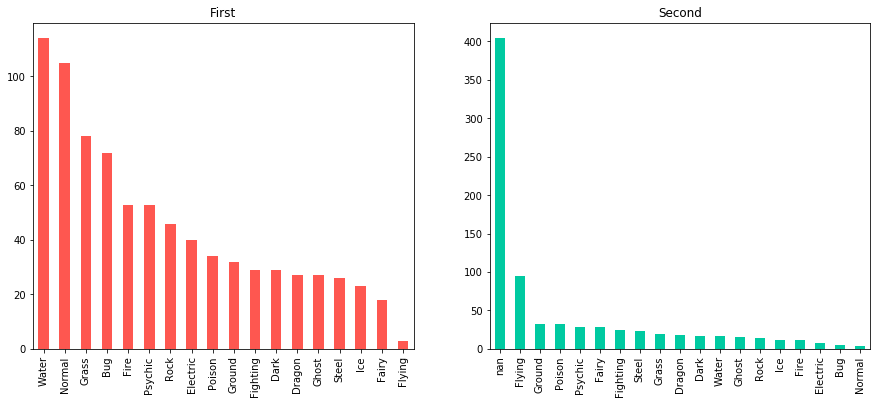

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 6))
unique_first_type.plot(kind='bar', ax=axes[0], title="First")
unique_second_type.plot(kind='bar', ax=axes[1], title="Second", color=sns.color_palette()[1])

### Type Distribution of Each Generation
> 各世代ごとのタイプ分布

In [0]:
kanto_list = all_data[:151]
jouto_list = all_data[151:251]
houen_list = all_data[251:386]
shinou_list = all_data[386:493]
ish_list = all_data[493:649]
karos_list = all_data[649:721]
alora_list = all_data[721:809]

generation_list = [kanto_list, jouto_list, houen_list, shinou_list, ish_list, karos_list, alora_list]
name_list = ['Kanto', 'Jouto', 'Houen', 'Shinou', 'Ish', 'Karos', 'Alora']

### Data Plot

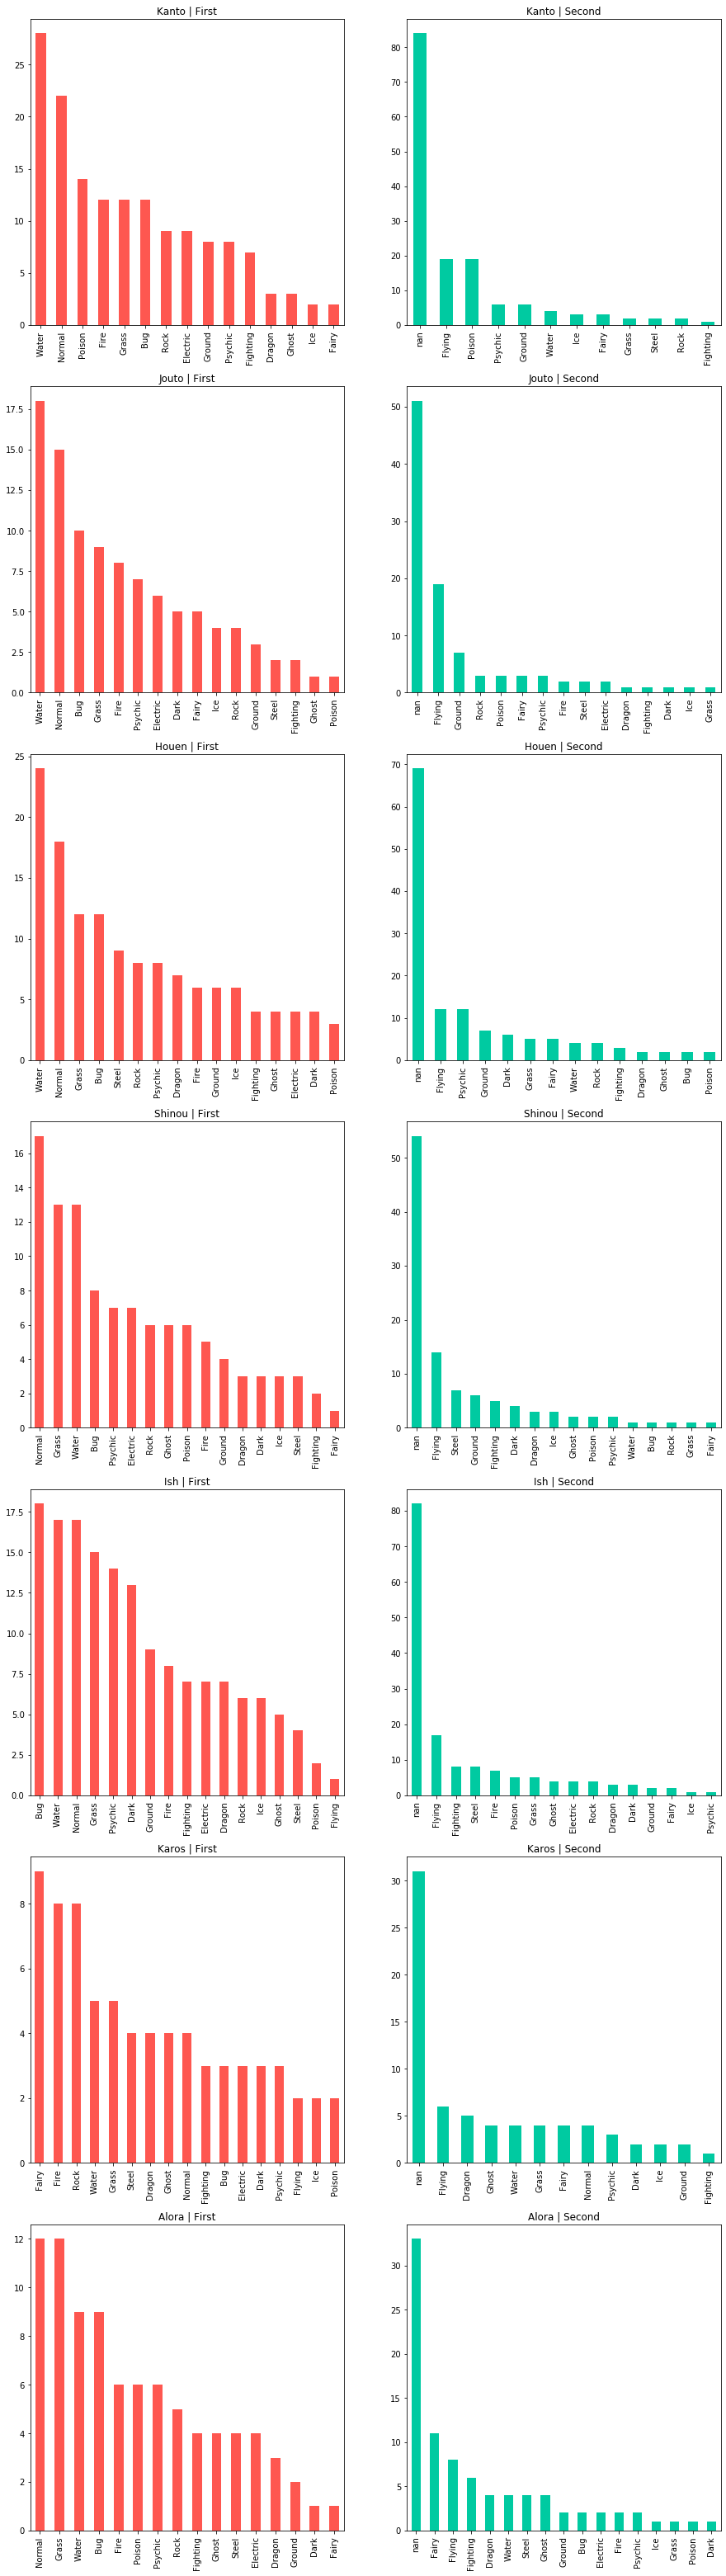

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=len(generation_list), figsize=(15, 8*len(generation_list)))

for idx, (generation, name) in enumerate(zip(generation_list, name_list)):
    unique_first_type = generation['First'].value_counts()
    unique_second_type = generation['Second'].value_counts()
    unique_first_type.plot(kind='bar', ax=axes[idx, 0], title="%s | First" % name)
    unique_second_type.plot(kind='bar', ax=axes[idx, 1], title="%s | Second" % name, color=sns.color_palette()[1])

##### Add `Generation` column describe which generation
> 第何世代かを示す属性 `Generation` を追加

In [0]:
def create_generation_column(separated_generation_num_list):

  _generation_list = pd.DataFrame(np.empty((809)), columns=['Generation'])

  _first_num = 0
  for gen_idx, num in enumerate(separated_generation_num_list, start=1):
    _generation_list[_first_num:num] = gen_idx

    _first_num = num


  return _generation_list


In [0]:
_each_generation_end_num = (151, 251, 386, 493, 649, 721, 809)

generation_number_column = create_generation_column(_each_generation_end_num)

all_data = pd.concat([all_data, generation_number_column], axis=1)

#### Status distribution of each generation
> 各世代のステータス分布

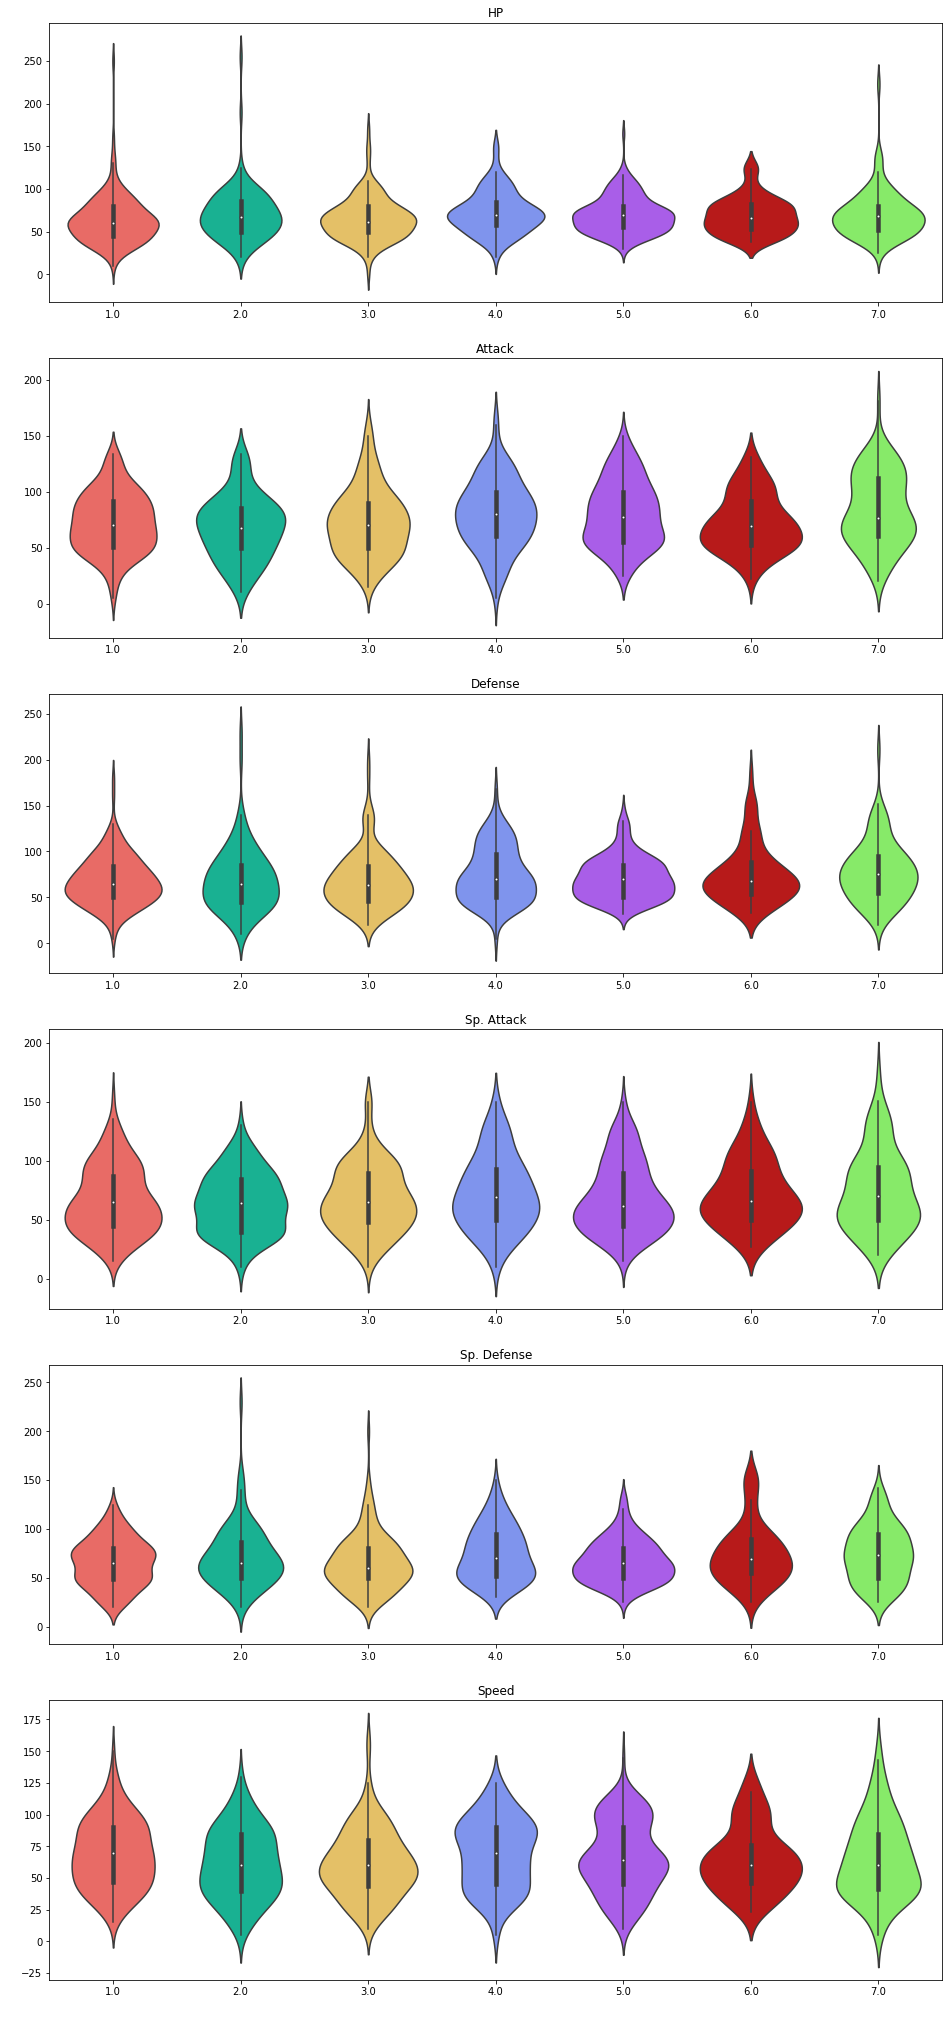

In [16]:
status_elements = ['HP', 'Attack', 'Defense', 'Sp. Attack', 'Sp. Defense',  'Speed']

fig, axes = plt.subplots(ncols=1, nrows=len(status_elements), figsize=(16, 6*len(status_elements)))

for idx, status in enumerate(status_elements):

  ax = sns.violinplot(x=all_data['Generation'], y=all_data[status], ax=axes[idx])
  ax.set_title(status)

### Add Legendary Flag
> `Legendary` フラグを追加

In [17]:
# Legendary No. List
legendary_number = list(range(143, 146))
legendary_number.extend(list(range(149, 151)))
legendary_number.extend(list(range(242, 245)))
legendary_number.extend(list(range(248, 251)))
legendary_number.extend(list(range(376, 386)))
legendary_number.extend(list(range(478, 493)))
legendary_number.extend(list(range(637, 649)))
legendary_number.extend(list(range(715, 721)))
legendary_number.extend(list(range(784, 809)))

print(legendary_number)

[143, 144, 145, 149, 150, 242, 243, 244, 248, 249, 250, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 715, 716, 717, 718, 719, 720, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808]


In [0]:
# Make Legendary Flag Column
_legendary_list = pd.DataFrame(np.empty((809)), columns=['Legendary'])
_legendary_list['Legendary'] = False
_legendary_list.iloc[legendary_number] = True


# Merged Legendary Flag Column
all_data = pd.concat([all_data, _legendary_list], axis=1)

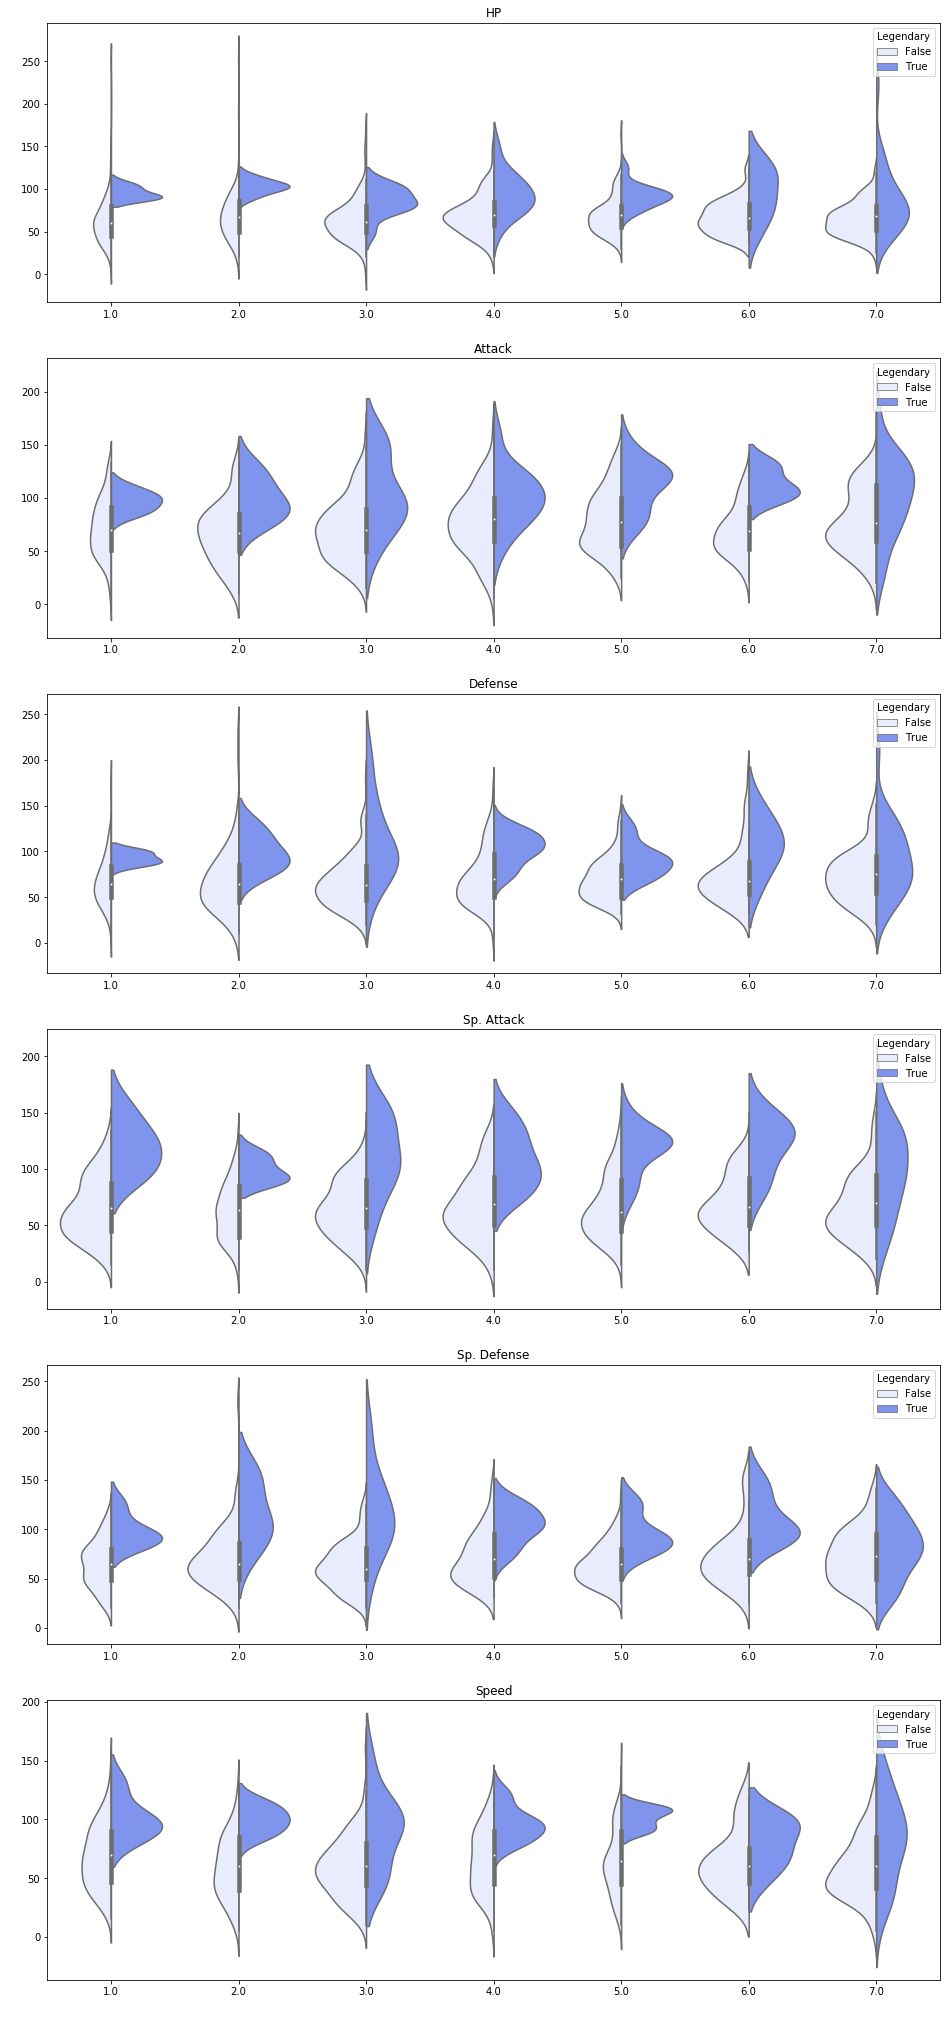

In [19]:
status_elements = ['HP', 'Attack', 'Defense', 'Sp. Attack', 'Sp. Defense',  'Speed']

fig, axes = plt.subplots(ncols=1, nrows=len(status_elements), figsize=(16, 6*len(status_elements)))

for idx, status in enumerate(status_elements):
  ax = sns.violinplot(x=all_data['Generation'], y=all_data[status], hue=all_data['Legendary'], split=True, ax=axes[idx], color=sns.color_palette()[3])
  ax.set_title(status)